In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip



--2023-06-03 14:51:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   201MB/s    in 0.8s    

2023-06-03 14:52:00 (201 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import zipfile

zip_file = zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_file.extractall()
zip_file.close()

In [4]:
# time to get the train and test data.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = "/content/10_food_classes_10_percent/train/"
test_data_dir = "/content/10_food_classes_10_percent/test/"

train_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

IMAGE_SIZE = (350, 350)
BATCH_SIZE= 32

train_data = train_data_gen.flow_from_directory(train_data_dir, class_mode="categorical", target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
test_data =  test_data_gen.flow_from_directory(test_data_dir, class_mode="categorical", target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

train_data, test_data

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


(<keras.preprocessing.image.DirectoryIterator at 0x7f6ce3b3c5b0>,
 <keras.preprocessing.image.DirectoryIterator at 0x7f6ce3b3d9f0>)

In [5]:
import datetime
import tensorflow as tf

# function to create a tensorboard callback. I though making it would be usefull in the long run when i will need to do multiple experiments and I would not need to create one every time.
def create_tensorboard_callback(dir_name, experiment_name):
  # the following will be the name of the directory to which we will save our experiments.
  log_directory = dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory)
  return tensorboard_callback


In [8]:
from keras.layers.serialization import activation
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# time to do feature extraction on the EfficientNetV1
model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, input_shape=IMAGE_SIZE+(3,), name="Feature_extraction_layer")

model = Sequential([
    feature_extractor_layer,
    layers.Dense(10, activation="softmax", name="Output_Layer")
])


In [9]:
# compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
# fit the data.
history = model.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name="Efficient_Net_B0", experiment_name="first experiment")])

Epoch 1/5
24/24 [==============================] - 51s 1s/step - loss: 1.9177 - accuracy: 0.4227 - val_loss: 1.3736 - val_accuracy: 0.7184
Epoch 2/5
24/24 [==============================] - 27s 1s/step - loss: 1.1444 - accuracy: 0.7587 - val_loss: 0.9268 - val_accuracy: 0.8204
Epoch 3/5
24/24 [==============================] - 27s 1s/step - loss: 0.8276 - accuracy: 0.8307 - val_loss: 0.7382 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 27s 1s/step - loss: 0.6653 - accuracy: 0.8667 - val_loss: 0.6406 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.5663 - accuracy: 0.8813 - val_loss: 0.5769 - val_accuracy: 0.8572


<Axes: >

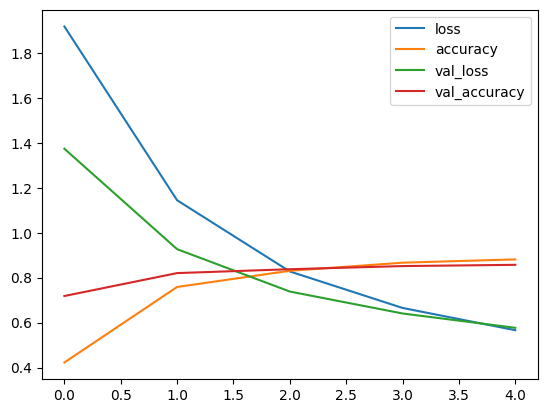

In [11]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 Output_Layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [14]:
pred = model.predict(test_data)

79/79 [==============================] - 27s 338ms/step


In [20]:

import numpy as np
import pathlib
dir = pathlib.Path("/content/10_food_classes_10_percent/train")
# we get all the classes that we have to predict.
classes = sorted([item.name for item in dir.glob("*")])
classes

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [27]:
def load_and_prepare_img(image, size=350):
  img = tf.io.read_file(image)

  # now convert it into a tensor and ensure that there are only 3 colo channels.
  img = tf.image.decode_image(img, channels=3)
  plt.imshow(img)
  # now convert it into a size on which our model was trained on.
  img = tf.image.resize(img, size=[size, size])
  
  # rescaling
  img /= 255
  return img

In [28]:
import matplotlib.pyplot as plt

def predict_model_output(model, image, classes):
  """ The function predicts the class of the provided image using the model given. """

  img = load_and_prepare_img(image)

  # make a prediction.
  pred = model.predict(tf.expand_dims(img, axis=0))

  # get the prediction label from the array of classes.
  prediction = classes[pred.argmax()]
  return prediction
  

1/1 [==============================] - 0s 28ms/step


'pizza'

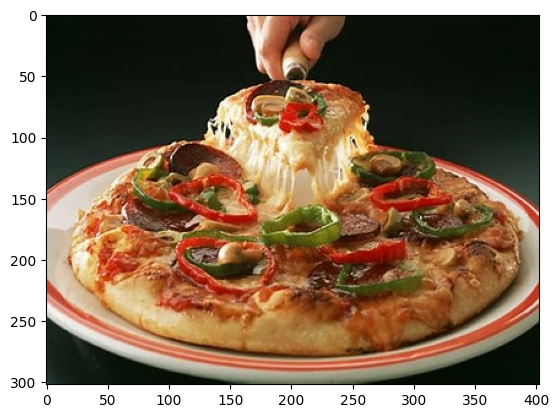

In [29]:
predict_model_output(model, "/content/test.jpeg" ,classes)